# Drift normalized by observing frequency vs. Burst Duration

,Unnamed: 0,trialDM,drift,drift_error,amplitude,xo,yo,sigmax,sigmay,theta,amp_error,xo_error,yo_error,sigmax_error,sigmay_error,angle_error
name,,,,,,,,,,,,,,,,
2.0,1,554.103000,-523.192968,0.325425,81.459955,512.492739,512.480978,181.111286,43.830037,1.854573,0.037464,0.030297,0.080149,0.083484,0.020150,0.000167
2.0,15,554.692158,-539.869375,0.347051,81.446010,512.492733,512.487604,180.696518,43.943243,1.846250,0.037492,0.029837,0.080219,0.083367,0.020220,0.000168
2.0,29,555.281316,-556.904803,0.368454,81.484384,512.493254,512.475564,180.316092,44.013651,1.838226,0.037440,0.029309,0.080065,0.083032,0.020212,0.000169
2.0,43,555.870474,-576.681853,0.394859,81.495295,512.493046,512.487994,179.921267,44.098165,4.971057,0.037424,0.028798,0.080024,0.082806,0.020241,0.000169
2.0,57,556.459632,-597.093127,0.423388,81.489314,512.493452,512.510366,179.543362,44.182993,4.962585,0.037423,0.028332,0.080027,0.082637,0.020281,0.000170
2.0,71,557.048789,-618.866956,0.453788,81.518695,512.493611,512.475387,179.181446,44.261598,1.812535,0.037351,0.027810,0.079841,0.082280,0.020270,0.000170
2.0,85,557.637947,-641.849072,0.489967,81.506377,512.493628,512.474689,178.846199,44.356964,11.228973,0.037467,0.027468,0.080105,0.082395,0.020380,0.000172
2.0,99,558.227105,-668.418418,0.532112,81.459256,512.493899,512.473503,44.445442,178.462963,3.366029,0.037479,0.027034,0.080162,0.020439,0.082291,0.000173
2.0,113,558.816263,-695.251927,0.573410,81.527992,512.493907,512.448148,178.116569,44.501842,4.928435,0.037365,0.026506,0.079838,0.081814,0.020386,0.000173


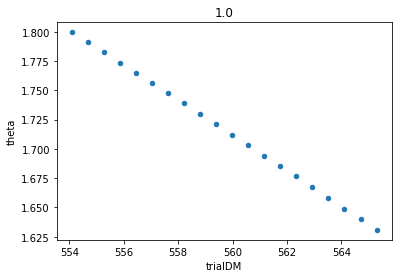

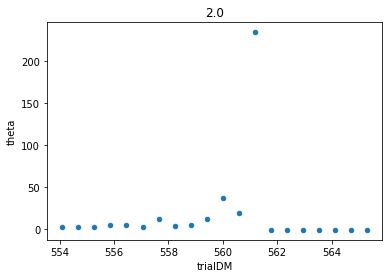

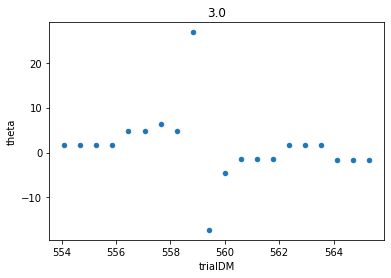

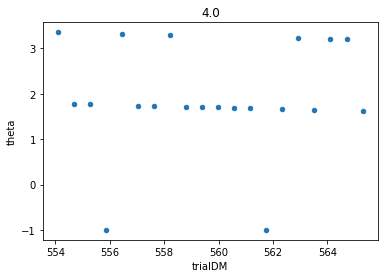

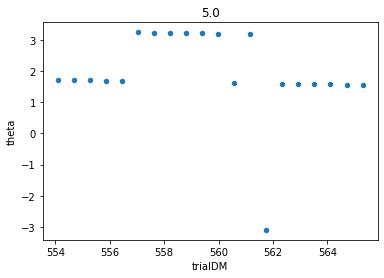

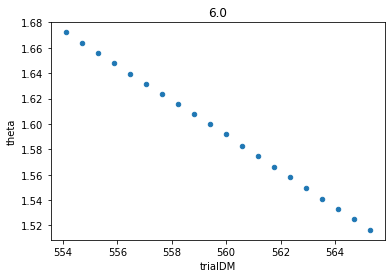

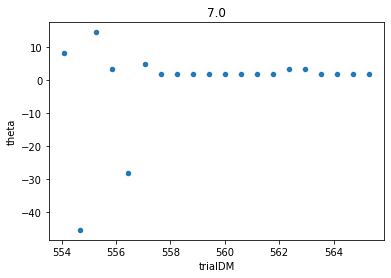

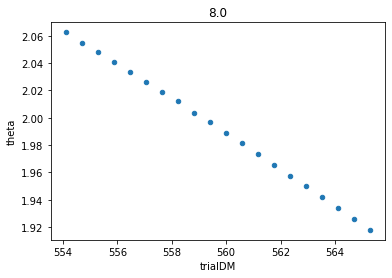

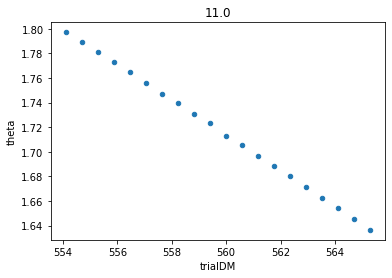

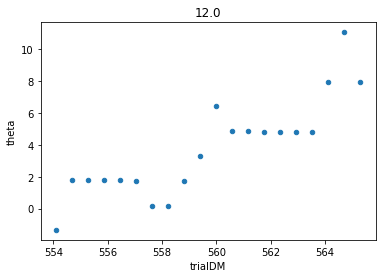

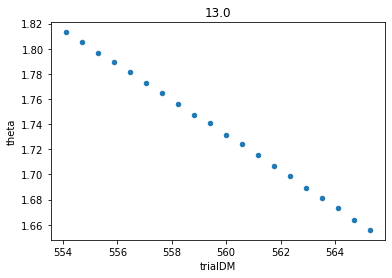

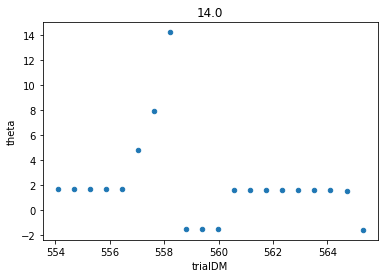

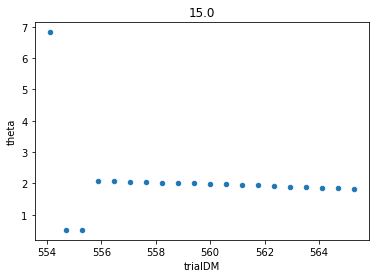

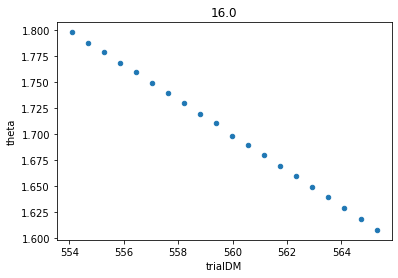

In [1]:
import pandas as pd
import numpy as np

covariancedata = pd.read_csv("frb121102_dmcovariance.csv")
covariancedata = covariancedata.set_index("name")
frb121102_centerDM = 559.7 # pc/cm^3


anglerange = []
for burst in covariancedata.index.unique():
    
    normalized_theta = [t if t < np.pi else t-np.pi for t in covariancedata.loc[burst]['theta'] % 2*np.pi] # theta is between 0 and pi
    anglerange.append([burst, np.min(normalized_theta), np.max(normalized_theta)])
    covariancedata.loc[burst].plot.scatter(x='trialDM', y='theta', title=str(burst))

covariancedata.loc[2]
# [t if t < np.pi else t-np.pi for t in covariancedata.loc[2]['theta'] % 2*np.pi]
    

In [1]:
import numpy as np
import scipy.stats
import scipy.odr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from tqdm import tqdm
import functools
print = functools.partial(print, flush=True) # print doesn't happen til script ends so force it to flush... windows thing?
import pandas as pd
import driftlaw

bursts121102 = pd.read_csv('data/aggregate/burstsFRB121102.csv') 
bursts121102 = bursts121102.set_index('name')
##########
bursts180916 = pd.read_csv('data/aggregate/burstsFRB180916.csv') 
bursts180916 = bursts180916.set_index('name')
bursts180916['time_res'] = 0.00098304 # s
#########
bursts180814 = pd.read_csv('data/aggregate/burstsFRB180814.csv') # DM = 188.9 pc/cm3
bursts180814 = bursts180814.set_index('name')
bursts180814['time_res'] = 0.00098304 # s, Not true for burst 180917
###########
burstsSGR1935 = pd.read_csv('data/aggregate/SGR1935+2154bursts.csv')
burstsSGR1935 = burstsSGR1935.set_index('name')
##########

# Set redshifts
bursts121102['z']  = 0.19273 # (josephy et al. 2019, frbcat.org)
bursts180916['z']  = 0.0337  # (chime 2020b et al.)
bursts180814['z']  = 0.05    # not accurate, z < 0.1 (amiri et al. 2019)
burstsSGR1935['z'] = 0       # ? galactic


#######
bursts121102 = driftlaw.computeModelDetails(bursts121102)
bursts121102.at['C1', 'tau_w_ms'] = 11.4
bursts121102.at['C1', 'tau_w'] = 11.4/1000
bursts121102.at['C1', 'tau_w_error'] = 0.12
bursts121102_to_include = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9a', 'M9b', 'M10a', 'M10b', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16', 'G11D', 'G11A1a', 'G11A1b', 'G11A2', 'G11A3', 'C1']
selectbursts121102 = bursts121102.loc[bursts121102_to_include]

bursts180916 = driftlaw.computeModelDetails(bursts180916)
selectbursts180916 = bursts180916

bursts180814 = driftlaw.computeModelDetails(bursts180814)
selectbursts180814 = bursts180814.drop(180917)

burstsSGR1935 = driftlaw.computeModelDetails(burstsSGR1935)
#display(bursts121102[['tau_w', 'tau_w_error']], bursts180916[['tau_w', 'tau_w_error']], bursts180814[['tau_w', 'tau_w_error']], burstsSGR1935[['tau_w', 'tau_w_error']])

In [2]:
fit_model = scipy.odr.Model(driftlaw.reciprocal_odr)
fit_model_log = scipy.odr.Model(driftlaw.reciprocal_odr_log)
# Color by source
selectbursts121102['color'] = 'r'#'c'
selectbursts121102.at[selectbursts121102.index > 'M', 'color'] = 'r'
selectbursts121102.at['C1', 'color'] = 'r'#'b'
selectbursts180916['color']          = 'b'
selectbursts180814['color']          = 'g'
burstsSGR1935['color']               = 'k'
michillibursts = selectbursts121102.head(18)
otherbursts = selectbursts121102.tail(6)
burstsSGR1935['drift (mhz/ms)']

name
CHIME1     -87.942225
CHIME2    -137.550708
B1       -5501.734912
B2       -3174.179985
S1        -463.136902
Name: drift (mhz/ms), dtype: float64

[0.08219169] [0.00578148]
[0.0823007] [0.00626765]
[0.0714318] [0.00999098]


<ipython-input-3-42e6dec11443>:122: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(x, opt[0]/x, l, label=lstr)
<ipython-input-3-42e6dec11443>:122: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(x, opt[0]/x, l, label=lstr)
<ipython-input-3-42e6dec11443>:122: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(x, opt[0]/x, l, label=lstr)


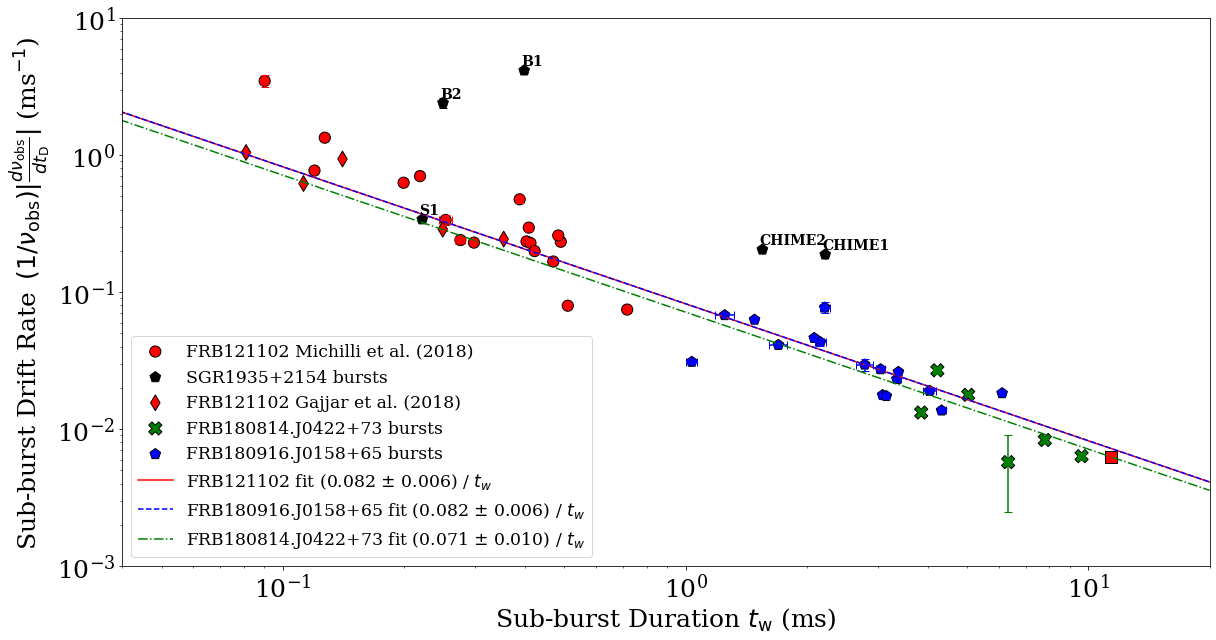

In [3]:
plt.rcParams["errorbar.capsize"] = 4
plt.rcParams["font.family"] = "serif"

markersize = 125#100
fontsize = 25 #18
annotsize = 14
logscale = True
filename = 'log_drift_over_nu_obsvsduration' if logscale else 'drift_over_nu_obsvsduration'
figsize = (17, 8)
figsize = (17, 9)
# figsize = (14, 10)


ax = michillibursts.plot.scatter(x='tau_w_ms', y='drift_over_nuobs', 
                               xerr=np.sqrt(michillibursts['red_chisq'])*michillibursts['tau_w_error'], 
                               yerr=np.sqrt(michillibursts['red_chisq'])*michillibursts['drift error (mhz/ms)']/michillibursts['center_f'], 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='o', edgecolors='k',
                               label='FRB121102 Michilli et al. (2018)')
    
selectbursts180916.plot.scatter(ax=ax, x='tau_w_ms', y='drift_over_nuobs', 
                               xerr=np.sqrt(selectbursts180916['red_chisq'])*selectbursts180916['tau_w_error'], 
                               yerr=np.sqrt(selectbursts180916['red_chisq'])*selectbursts180916['drift error (mhz/ms)']/selectbursts180916['center_f'], 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='p', edgecolors='k',
                               label='FRB180916.J0158+65 bursts')
selectbursts180814.plot.scatter(ax=ax, x='tau_w_ms', y='drift_over_nuobs', 
                               xerr=np.sqrt(selectbursts180814['red_chisq'])*selectbursts180814['tau_w_error'], 
                               yerr=np.sqrt(selectbursts180814['red_chisq'])*selectbursts180814['drift error (mhz/ms)']/selectbursts180814['center_f'], 
                               figsize=figsize, s=markersize+50, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='X', edgecolors='k',
                               label='FRB180814.J0422+73 bursts')
                               #label='FRB180814.J0422+73 bursts @ DM={} pc/cm$^3$'.format(dms180814[dm_idx]))
burstsSGR1935.plot.scatter(ax=ax, x='tau_w_ms', y='drift_over_nuobs', 
                               xerr=np.sqrt(burstsSGR1935['red_chisq'])*burstsSGR1935['tau_w_error'], 
                               yerr=np.sqrt(burstsSGR1935['red_chisq'])*burstsSGR1935['drift error (mhz/ms)']/burstsSGR1935['center_f'], 
                               figsize=figsize, s=markersize, c='color', colorbar=False, fontsize=fontsize, logy=logscale, logx=logscale, marker='p', edgecolors='k',
                               label='SGR1935+2154 bursts')

otherbursts.head(5).plot.scatter(ax=ax, x='tau_w_ms', y='drift_over_nuobs',
                         xerr=np.sqrt(otherbursts['red_chisq'])*otherbursts['tau_w_error'], 
                         yerr=np.sqrt(otherbursts['red_chisq'])*otherbursts['drift error (mhz/ms)']/otherbursts['center_f'], edgecolors='k',
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='d', label='FRB121102 Gajjar et al. (2018)') 
otherbursts.tail(1).plot.scatter(ax=ax, x='tau_w_ms', y='drift_over_nuobs',
                         xerr=np.sqrt(otherbursts['red_chisq'])*otherbursts['tau_w_error'], 
                         yerr=np.sqrt(otherbursts['red_chisq'])*otherbursts['drift error (mhz/ms)']/otherbursts['center_f'], edgecolors='k',
                         figsize=figsize, s=markersize, c='color', colorbar=False, marker='s', label='FRB121102 Josephy et al. (2019)') 

# for k, v in otherbursts.iterrows():
#     ax.annotate(k+'_c', (v['tau_w_ms'], v['drift_over_nuobs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in michillibursts.iterrows():
#     ax.annotate(k, (v['tau_w_ms'], v['drift_over_nuobs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in selectbursts180916.iterrows():
#     ax.annotate(int(k) if k != 15.5 else k, (v['tau_w_ms'], v['drift_over_nuobs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
for k, v in burstsSGR1935.iterrows():
    if v['drift_over_nuobs'] > 0 or not logscale:
        ax.annotate(k, (v['tau_w_ms'], v['drift_over_nuobs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)
# for k, v in selectbursts180814.iterrows():
#     if v['drift_over_nuobs'] > 0:
#         ax.annotate(k, (v['tau_w_ms'], v['drift_over_nuobs']), xytext=(-3,5), textcoords='offset points', weight='bold', size=annotsize)

if not logscale:
    pass
    # ax.set_xlim(-0.1, 20)
    # ax.set_ylim(-0.2, 4)
elif logscale:
    ax.set_xlim(0.04, 20)
    ax.set_ylim(10**-3, 10**1)

# ax.set_title('Sub-burst Drift Rate vs. Burst Duration (fit to Michilli bursts)', size=fontsize)
ax.set_xlabel('Sub-burst Duration $t_\\mathrm{w}$ (ms)', size=fontsize)
ax.set_ylabel('Sub-burst Drift Rate $\,(1/\\nu_{\\mathrm{obs}}) \left|\\frac{d\\nu_\\mathrm{obs}}{dt_\\mathrm{D}}\\right|$ (ms$^{-1}$)', size=fontsize)

def driftnu_error(frame):
    sx = np.log((frame['tau_w_ms'] + np.sqrt(frame['red_chisq'])*frame['tau_w_error']) / frame['tau_w_ms'])
    sy = np.log((frame['drift_over_nuobs'] + np.sqrt(frame['red_chisq'])*(frame['drift error (mhz/ms)'])) / frame['drift_over_nuobs'])
    return sx, sy

# ODR fit log
num_to_fit = 24 #23 to exlude chime
fitdata_log = scipy.odr.RealData(np.log(selectbursts121102.head(num_to_fit)['tau_w_ms']), 
                             np.log(selectbursts121102.head(num_to_fit)['drift_over_nuobs']),
                             sx=driftnu_error(selectbursts121102.head(num_to_fit))[0],
                             sy=driftnu_error(selectbursts121102.head(num_to_fit))[1])
                             #sx=np.log(np.sqrt(selectbursts121102.head(num_to_fit)['red_chisq'])*selectbursts121102.head(num_to_fit)['tau_w_error']), 
                             #sy=np.log(np.sqrt(selectbursts121102.head(num_to_fit)['red_chisq'])*selectbursts121102.head(num_to_fit)['drift error (mhz/ms)']/selectbursts121102.head(num_to_fit)['center_f']))
odrfitter_log = scipy.odr.ODR(fitdata_log, fit_model_log, beta0=[500])
odrfitter_log.set_job(fit_type=0)
odrfit_log = odrfitter_log.run()

# ODR fit log 180916
fitdata_log_180916 = scipy.odr.RealData(np.log(selectbursts180916['tau_w_ms']), 
                             np.log(selectbursts180916['drift_over_nuobs']),
                             sx=driftnu_error(selectbursts180916)[0],
                             sy=driftnu_error(selectbursts180916)[1])
                             #sx=np.log(np.sqrt(selectbursts180916['red_chisq'])*selectbursts180916['tau_w_error']), 
                             #sy=np.log(np.sqrt(selectbursts180916['red_chisq'])*selectbursts180916['drift error (mhz/ms)']/selectbursts180916['center_f'] ))
odrfitter_log180916 = scipy.odr.ODR(fitdata_log_180916, fit_model_log, beta0=[1000])
odrfitter_log180916.set_job(fit_type=0)
odrfit_log180916 = odrfitter_log180916.run()

# ODR fit log 180814
fitdata_log_180814 = scipy.odr.RealData(np.log(selectbursts180814['tau_w_ms']), 
                             np.log(selectbursts180814['drift_over_nuobs']),
                             sx=driftnu_error(selectbursts180814)[0],
                             sy=driftnu_error(selectbursts180814)[1])
                             #sx=np.log(np.sqrt(selectbursts180814['red_chisq'])*selectbursts180814['tau_w_error']), 
                             #sy=np.log(np.sqrt(selectbursts180814['red_chisq'])*selectbursts180814['drift error (mhz/ms)']/selectbursts180814['center_f'] ))
odrfitter_log180814 = scipy.odr.ODR(fitdata_log_180814, fit_model_log, beta0=[1000])
odrfitter_log180814.set_job(fit_type=0)
odrfit_log180814 = odrfitter_log180814.run()

### Plot fits
x = np.linspace(0, 20, num=1200)
opts  = [np.exp(odrfit_log.beta), np.exp(odrfit_log180916.beta), np.exp(odrfit_log180814.beta)]
errs  = [opts[0]*(np.exp(odrfit_log.sd_beta)-1), opts[1]*(np.exp(odrfit_log180916.sd_beta)-1), opts[2]*(np.exp(odrfit_log180814.sd_beta)-1)]
#errs  = [np.exp(odrfit_log.sd_beta), np.exp(odrfit_log180916.sd_beta), np.exp(odrfit_log180814.sd_beta)]
#names = ['Fit from FRB121102 bursts', 'Fit from FRB180916.J0158+65 bursts', 'Fit from FRB180814.J0422+73 bursts']

names = ['FRB121102 fit', 'FRB180916.J0158+65 fit', 'FRB180814.J0422+73 fit']
ls    = ['r-', 'b--', 'g-.']
for opt, err, name, l in zip(opts, errs, names, ls):
    print(opt, err)
    lstr = '{} ({:.3f} $\pm$ {:.3f}) / $t_w$'.format(name, opt[0], err[0])
    plt.plot(x, opt[0]/x, l, label=lstr)

handles, labels = ax.get_legend_handles_labels()
#handles = [handles[0], handles[2], handles[4], handles[5], handles[1], handles[3]]
#labels = [labels[0], labels[2], labels[4], labels[5], labels[1], labels[3]]
# handles = [handles[2], handles[5], handles[6], handles[4], handles[3], handles[0], handles[1]]
# labels = [labels[2], labels[5], labels[6], labels[4], labels[3], labels[0], labels[1]]
handles = [handles[3], handles[6], handles[7], handles[5], handles[4], handles[0], handles[1], handles[2]]
labels = [labels[3], labels[6], labels[7], labels[5], labels[4], labels[0], labels[1], labels[2]]
plt.legend(handles, labels, fontsize='xx-large')
# 2 digits, ytitle

# plt.title("Non Redshift Corrected", size=20)
#plt.title("FRB121102, FRB180916.J0158+65, and FRB180814.J0422+73", size=20)
plt.tight_layout()
# plt.savefig('180814_dm{}.png'.format(dms180814[dm_idx]))
# print('180814_dm{}.png'.format(dms180814[dm_idx]))
# for f in ['png', 'pdf', 'eps']: plt.savefig('figures/{}.{}'.format(filename, f))
# for f in ['png']: plt.savefig('figures/{}.{}'.format(filename, f))